In [1]:
#Earth-Moon Example 1

#import the packages from the local environment
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

  Activating project at `~/Research/cvx-mpc-solarsailing`


In [2]:
using LinearAlgebra
using ForwardDiff
using SatelliteDynamics
using DifferentialEquations
using Plots
using ECOS, Convex
using Mosek, MosekTools
using SPICE 

#trying out Clarabel 
using Clarabel
using BenchmarkTools
using DelimitedFiles

In [3]:
include("../src/dynamics.jl")
include("../src/parameters.jl")
include("../src/integrate.jl")
include("../src/fmincon.jl")
include("../src/transformations.jl")
include("../src/solve.jl")
include("../src/solve_projection.jl")

get_matrix_solution (generic function with 1 method)

In [4]:
#this is the code to download the leap seconds kernel and planetary ephemeris kernels! Only need to do this once 

# using Downloads: download

# const LSK = "https://naif.jpl.nasa.gov/pub/naif/generic_kernels/lsk/naif0012.tls"
# const SPK = "https://naif.jpl.nasa.gov/pub/naif/generic_kernels/spk/planets/de440.bsp"

# # Download kernels
# download(LSK, "naif0012.tls")
# download(SPK, "de440.bsp")

In [5]:
#change these links to the location of the leap seconds kernel and planetary ephemeris kernel
seconds_kernel = "/home/faustovega/Desktop/astrodynamics_nasa_work/naif0012.tls"

ephemeris_kernel = "/home/faustovega/Desktop/astrodynamics_nasa_work/de440.bsp"

"/home/faustovega/Desktop/astrodynamics_nasa_work/de440.bsp"

In [6]:
#load leap seconds kernel
furnsh(seconds_kernel)
furnsh(ephemeris_kernel)

In [7]:
Earth_Moon = ThreeBodySystem_EarthMoon()

ThreeBodySystem(0.01215, 0.98785, 0.01215, 4.0, [-0.01215, 0.0, 0.0], [0.98785, 0.0, 0.0], 385000.0, 4.349129868518112, 88523.45449302066, 20354.29089708545, [0.8369180073169304, 0.0, 0.0, 0.0, 0.0, 0.0], [1.1556799130947355, 0.0, 0.0, 0.0, 0.0, 0.0])

In [8]:
#period of the halo in cr3bp units
T = 3.4071472466192527

#period in custom units
T_scaled = T*Earth_Moon.time_scale

#read in the initial guess trajectory. Richardson expansion from ThreeBodyProblem.jl
richardson  = readdlm("../refs/richardsonL2.txt", '\t', Float64, '\n')'

#in CR3BP units
x0_L2 = richardson[:,1]

x0_L2_scaled = [x0_L2[1:3]*Earth_Moon.position_scale; x0_L2[4:6]*Earth_Moon.velocity_scale]

6-element Vector{Float64}:
 431249.946141646
      0.0
   5642.062948909701
      0.0
  15342.188285037404
      0.0

In [9]:
Φ_0 = vec(Matrix(1.0*I, 6,6))
x_0_stm = [x0_L2_scaled; Φ_0]

solution_in = dynamics_integrate(Earth_Moon, x_0_stm, T_scaled)

all_state_in, stm_in, sol_t_in = get_state_stm(solution_in)

([431249.946141646 431249.9461444589 … 369544.74912909867 369665.9710674015; 0.0 2.1072953725303933 … -45031.76538735194 -45157.53537524888; … ; 15342.188285037404 15342.188246755026 … -2527.477147320156 -1571.3827010368555; 0.0 -0.23903800908705172 … 2308.451334796891 2425.0874238384185], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0;;; 1.00000000622429 5.594567641213317e-14 … 4.337843062628147e-9 3.924109594110078e-14; -2.434276316857394e-14 0.9999999975890765 … 0.0001373529858999031 1.8119307154423863e-19; … ; -5.316833039735577e-10 -3.510551179617628e-5 … 0.999999995594267 5.2767129716926075e-15; 1.2480045464823515e-5 2.5469638239204106e-10 … 4.136769856380186e-14 0.9999999971840383;;; 1.0000000249515597 4.4903309225312285e-13 … 1.7389284798030495e-8 3.14958220963991e-13; -1.9538071544537643e-13 0.999999990335235 … 0.00027500592068671945 2.9117718373904653e-18; … ; -2.1313800807912153e-9 -7.028768607178565e-5 … 0.9999999823385622 4.2352132190747765

In [10]:
#fix with a single shooting differential corrector
function differential_corrector(system, x_0_stm, Tp)
    
    #this is the final time it converges to
    T_f = 0

    #Iterate to bring the δx at T/2 to the desired state
    max_iters = 1000

    #keep z0 fixed and change only x0 and y_dot_0
    for i=1:max_iters

        solution = diff_solve(system, x_0_stm, Tp)

        #this is the state, STM, and time when y crosses the XZ plane 
        all_state, stm, sol_t = get_state_stm(solution)

        T2_state = all_state[:,end]

        #T2_state -> x,y,z, xdot, ydot, zdot
        #desired xdot an xzdot
        xz_d = [0, 0]

        rv = T2_state[1:6]

        rv_dot = three_body_prob_dynamics_scaled(system, rv)

        #desired state subtracted by state at t/2
        δxz = xz_d - [T2_state[4], T2_state[6]]

        #keep x0 constant
        stm_s = [stm[4,3, end] stm[4,5,end]; stm[6,3,end] stm[6,5,end]]
        dy = [rv_dot[4]; rv_dot[6]]*[stm[2,3,end] stm[2,5,end]]


        delta_x0 = (stm_s - dy/rv_dot[2])\δxz

        #x_0_stm[1] = x_0_stm[1] + delta_x0[1]
        x_0_stm[3] = x_0_stm[3] + delta_x0[1]
        x_0_stm[5] = x_0_stm[5] + delta_x0[2]

        println("residual: ", δxz)
        
        #loosen up the tolerance bc of the scaling of the problem
        if norm(δxz) < 1e-6
                    
            T_f = sol_t[end]*2
            break
        end

    end
    
    corrected_solution = dynamics_integrate(system, x_0_stm, T_f)

    all_state_final, stm_final, sol_t_final = get_state_stm(corrected_solution)
    
    return all_state_final, stm_final, sol_t_final, corrected_solution
    
end

differential_corrector (generic function with 1 method)

In [11]:
#run the differential corrector to get the corrected solution
all_state_final, stm_final, sol_t_final, full_solution = differential_corrector(Earth_Moon, x_0_stm, T_scaled)

residual: [1643.9519839324487, -191.4988002731686]
residual: [2.5062654060160137, 35.414091821322586]
residual: [-495.1171688605523, 60.688781643238784]
residual: [-24.375558852836726, 8.506875803296856]
residual: [-110.46860206507704, 9.540111536783268]
residual: [-13.136193716304701, 1.758026940039784]
residual: [-14.47295436376987, 1.0122384454524755]
residual: [-1.5051816256491617, 0.1252862858144221]
residual: [-0.11466721336305255, 0.007759735519665084]
residual: [-0.0002584322764384862, 1.3541399399075671e-5]
residual: [-4.466341804239009e-6, -1.6699838992584847e-7]
residual: [-1.7181652133684486e-6, -6.467597166466907e-8]
residual: [4.390998454090687e-7, 1.6642285394796388e-8]


([431249.946141646 431249.94614368404 … 431250.7570701569 431249.9459525911; 0.0 2.118659307545513 … -1332.0877095001688 0.0002245328881018195; … ; 15649.016257820032 15649.016219624365 … 15633.915771830501 15649.016342283901; 0.0 -0.09679765124423992 … 60.838081487480196 -7.527633835777027e-6], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0;;; 1.0000000061999952 5.746812490061226e-14 … 4.2144974216198e-9 1.5618037605153313e-14; -2.178985779599666e-14 0.9999999976191183 … 0.00013538610167654265 7.747337710088622e-20; … ; -4.828381381064227e-10 -3.5171730170269434e-5 … 0.9999999956810306 2.28896100118786e-15; 5.112455571955675e-6 1.0493438156541656e-10 … 1.6653248151092917e-14 0.9999999971499303;;; 1.0000000255866435 4.817924242782896e-13 … 1.739273010437185e-8 1.309361013432194e-13; -1.8267845868207107e-13 0.9999999901743841 … 0.000275033162472087 1.3194605279971914e-18; … ; -1.9926156055396843e-9 -7.145040750929283e-5 … 0.9999999821761268 1.91898386168

In [12]:
#integrate the trajectory to see how many revs it does before it leaves (unstable halo orbit)

#does two revs, after the third rev is significantly deviates. blows up at the 4th 

xtraj_sol = just_dynamics_integrate(Earth_Moon, all_state_final[:,1] , 4*sol_t_final[end] )

xtraj_test = get_state(xtraj_sol)

6×521 Matrix{Float64}:
     4.3125e5      4.3125e5   …       3.95754e5       3.95043e5
     0.0           1.72978          507.918        1530.5
  2286.77       2286.77             866.676         872.628
     0.0           0.0245808     -31382.4        -34311.5
 15649.0       15649.0            47146.6         47238.1
     0.0          -0.0790305  …     372.564         172.621

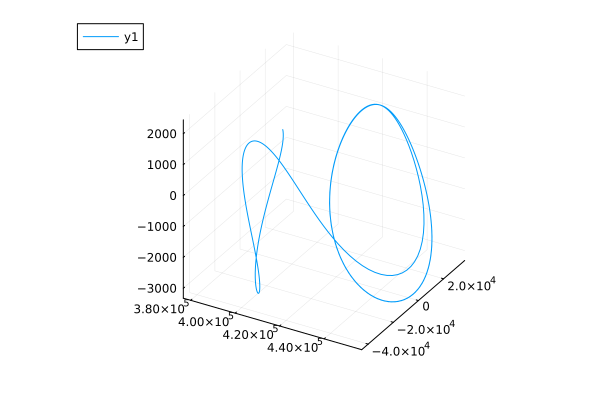

In [13]:
plot(xtraj_test[1,:], xtraj_test[2,:], xtraj_test[3,:]) 

In [14]:
#number of states
nx = 6 

#number of controls 
nu = 3

3

In [15]:
#this is the number of knot points in one horizon
N_period = 81  

N_h = 161 #horizon 2 periods

#this is the time step. (period T is already scaled). for 1 period
# 100 poi
Δt = (sol_t_final[end]/(N_period-1))

0.1856521445875789

In [16]:
#this is along 1 period of the reference orbit
all_Ad = zeros(6,6,N_period)
all_Bd = zeros(6,3,N_period)

6×3×81 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

;;; … 

[:, :, 79] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 80] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

[:, :, 81] =
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [17]:
T_corrected = sol_t_final[end] 

14.852171567006312

In [18]:
#horizon for 1 revolution 
horizon = LinRange(0, T_corrected, N_period)

#horizon for 2 revolutions 
horizon2 = LinRange(0, T_corrected*2, N_h) 

#this is 102 revolutions worth of time data. For the sun trajectory 
horizon102 = LinRange(0,T_corrected*102, (N_period)+(101*(N_period-1)))

8161-element LinRange{Float64, Int64}:
 0.0, 0.185652, 0.371304, 0.556956, …, 1514.36, 1514.55, 1514.74, 1514.92

In [19]:
#used to save the state transition matrix at each knot point
stm_times = zeros((6,6,N_period))

6×6×81 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

;;; … 

[:, :, 79] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 80] =
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0


In [20]:
#get the reference trajectory
reference_trajectory = zeros(nx, N_period)

for k=1:N_period

    reference_trajectory[:,k] = full_solution(horizon).u[k][1:6]
    
    #save the reference state transition matrices at the dedicated timesteps
    
    stm_times[:,:,k] = reshape(full_solution(horizon).u[k][7:end], (6,6)) 
        
end

In [21]:
#get the discrete dynamics jacobians for the entire reference trajectory along the knot points
for i=1:N_period

    all_Ad[:,:,i] = ForwardDiff.jacobian(x_-> RK4_integrator(Earth_Moon, x_, zeros(3)), reference_trajectory[:,i])


    all_Bd[:,:,i] = ForwardDiff.jacobian(u_-> RK4_integrator(Earth_Moon, reference_trajectory[:,i], u_), zeros(3))
    
    
end

In [22]:
#set of dynamics jacobians for 2 revolutions 
all_Ad_1 = cat(all_Ad, all_Ad[:,:,2:end], dims=3)
all_Bd_1 = cat(all_Bd, all_Bd[:,:,2:end], dims=3)

6×3×161 Array{Float64, 3}:
[:, :, 1] =
  0.00431408   0.000122903  4.65041e-7
 -0.000122311  0.00430252   1.30881e-8
  4.65041e-7   1.30881e-8   0.0043045
  0.046536     0.0019919    9.98179e-6
 -0.00197291   0.0462882    2.0599e-7
  9.96387e-6   6.31827e-7   0.0463304

[:, :, 2] =
  0.00431394   0.000123478  4.52595e-7
 -0.000121737  0.00430262   3.80436e-8
  4.52595e-7   3.80436e-8   0.00430453
  0.0465325    0.00200402   9.66198e-6
 -0.00196075   0.0462908    7.34709e-7
  9.62174e-6   1.14641e-6   0.0463312

[:, :, 3] =
  0.00431369   0.000124004  4.28937e-7
 -0.000121211  0.00430281   5.96671e-8
  4.28937e-7   5.96671e-8   0.00430459
  0.0465265    0.00201494   9.10967e-6
 -0.00194976   0.0462953    1.18717e-6
  9.05057e-6   1.57487e-6   0.0463328

;;; … 

[:, :, 159] =
  0.00431394    0.000121737   4.52612e-7
 -0.000123477   0.00430262   -3.8007e-8
  4.52612e-7   -3.8007e-8     0.00430453
  0.0465346     0.00196672    9.82427e-6
 -0.00199807    0.0462893    -8.96843e-7
  9.85367e-

In [23]:
#define initial condition 

x_initial_ref = [1e-6, 1e-6, 1e-6, 1811.22e-6, 1811.22e-6, 1811.22e-6]

x_initial_ref_scaled = [x_initial_ref[1:3]*Earth_Moon.position_scale*1.0; x_initial_ref[4:6]*Earth_Moon.velocity_scale*0.1]

6-element Vector{Float64}:
  0.385
  0.385
  0.385
 16.03354512468489
 16.03354512468489
 16.03354512468489

In [24]:
#this is what happens with the injection error applied to the first timestep of the halo orbit 

solution_deviation = just_dynamics_integrate(Earth_Moon, reference_trajectory[:,1] + x_initial_ref_scaled, sol_t_final[end])

all_states_deviation = get_state(solution_deviation)

6×112 Matrix{Float64}:
     4.3125e5      4.3125e5      4.3125e5  …       4.51163e5       4.51452e5
     0.385         3.4346        6.89795      -28842.1        -28741.6
  2287.16       2287.16       2287.16           2500.64         2518.05
    16.0335       16.0783       16.1292        10083.3         10238.6
 15665.0       15665.0       15665.0            3572.55         3488.51
    16.0335       15.8943       15.7362    …     615.435         607.383

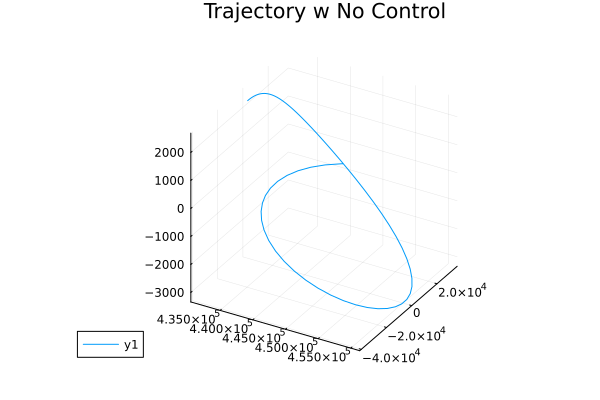

In [25]:
plot(all_states_deviation[1,:], all_states_deviation[2,:], all_states_deviation[3,:], title="Trajectory w No Control")  

In [26]:
#this is the reference trajectory for 2 orbits starting at the beginning
reference_trajectory2 = [reference_trajectory reference_trajectory[:,2:end]] 

6×161 Matrix{Float64}:
     4.3125e5      4.31254e5  431267.0    …      4.31254e5      4.3125e5
     0.0        2900.84         5775.21      -2900.84           0.000224533
  2286.77       2274.47         2237.81       2274.47        2286.77
     0.0          43.6726        101.372       -43.673         -0.000128932
 15649.0       15577.4         15364.7       15577.4        15649.0
     0.0        -132.301        -262.025  …    132.301         -7.52763e-6

In [27]:
reference_trajectory_half = cat(reference_trajectory[:,21:end], reference_trajectory[:,2:21], dims=2)

#this is the reference trajectory starting at the half 21
reference_trajectory2_2 = cat(reference_trajectory_half, reference_trajectory_half[:,2:end], dims=2)

6×161 Matrix{Float64}:
     4.39506e5      4.40518e5      4.41558e5  …      4.38531e5      4.39506e5
 33760.7        33528.5        33101.6           33795.4        33760.7
  -838.792      -1039.57       -1235.14           -633.698       -838.792
  5359.03        5534.78        5662.27           5137.92        5359.03
  -721.111      -1777.86       -2818.04            348.046       -721.111
 -1093.92       -1068.21       -1037.87       …  -1114.67       -1093.92

In [28]:
#horizon in seconds 
horizon_s = horizon * 86400 

#number of elements in the 102 rev horizon 
N_s = size(horizon102)[1]

8161

In [29]:
#these will be in the cr3bp frame 
sun_positions = zeros(3, N_s)  

3×8161 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [30]:
#define initial epoch 
epc = Epoch("2018-12-20")

#puts that date into seconds...
et = utc2et("2018-12-20T20:00:00")

5.986080691835953e8

In [31]:
#area of the sail
A = 10 #Area: m2 

#from the optimal solar sail trajectories for missions to the outer solar system paper
W = 1368 #solar flux at the sun earth distance (units: J/s m2)

1368

In [32]:
#create an empty array to add in all the epochs of the sun positions 
epochs = []

for i=1:N_s
    push!(epochs, epc + horizon102[i]*86400)
end


#get the sun positions in cr3bp frame (barycenter)
for i=1:N_s
    sun_pose_eci = sun_position(epochs[i])

    #multiplying by 1e-3 to get in km
    sun_positions[:,i] , _ = eci_to_cr3bp(Earth_Moon, sun_pose_eci, horizon102[i]*86400).*1e-3
end

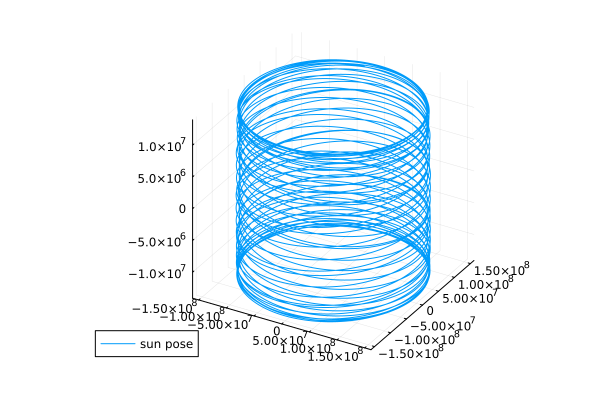

In [33]:
#these sun positions are in the barycentric frame!
plot(sun_positions[1,:], sun_positions[2,:], sun_positions[3,:], label = "sun pose")

In [34]:
#reference trajectory for 100 revolutions 
reference_trajectory102 = zeros(6, N_s)

reference_trajectory102[:, 1:81] = reference_trajectory

lower_bound = 82
upper_bound = 161

for i=1:101

    reference_trajectory102[:, lower_bound:upper_bound] = reference_trajectory[:,2:end]

    lower_bound += 80
    upper_bound += 80

end

#get the vector pointing toward the halo orbit and the sun. incident sun direction (not normalized yet)
sun_satellite_position = zeros(3,N_s)

for i=1:N_s
    sun_satellite_position[:,i] = reference_trajectory102[1:3,i] - sun_positions[:,i]
end


In [35]:
#get the maximum force the sail can produce
gammas = zeros(N_s)

#this is km/day2
for i=1:N_s
    #have to multiply it by a scale to get it in the correct units
    gammas[i] = ((2*A*W/C_LIGHT)*(norm(sun_positions[:,i] - (Earth_Moon.pose_m1*Earth_Moon.position_scale))/norm(sun_satellite_position[:,i]))^2)*(86400^2/1000)

end

In [36]:
#only using 1 gamma to simplify the problem. using the average
avg_gamma = sum(gammas)/N_s 

681.2695456580024

In [37]:
#units of kg m/s2
# Newtons 
max_force = avg_gamma*(1000/(86400^2))

9.126231696593182e-5

In [38]:
#this is for 10 m2
#this is size of the other axis of the ellipsoid. Obtained through least squares approximation code

alpha = 521.6282903145556

#eigenvalues for the elipsoid
eig_1 = (1/(avg_gamma/2))^2
eig_2 = (1/(alpha/2))^2
eig_3 = (1/(alpha/2))^2

1.4700689914879715e-5

In [39]:
#normalize incident sun vector
sun_satellite_position_normal = zeros(3, N_s) 

for i=1:N_s
    sun_satellite_position_normal[:,i] = sun_satellite_position[:,i]/norm(sun_satellite_position[:,i])
end

In [40]:
#one iteration of solve

cons, X, U = update_prob(Earth_Moon, x_initial_ref_scaled, all_Ad_1, all_Bd_1, reference_trajectory2, sun_satellite_position_normal[:, 1:N_h])

#only penalizing reference deviation
Xm, Um, status_m = solve_opt(cons, X, U, N_h)

println("This is status: ", Int(status_m))

This is status: 1


In [41]:
@btime Xm, Um, status_m = solve_opt(cons, X, U, N_h)

  108.682 ms (517850 allocations: 94.03 MiB)


([0.38499999995469436 3.667930924067896 … 0.0009810570028093812 0.000520711985358025; 0.3850000000004873 2.978585728556722 … 0.001678680461049961 0.0017471671476262413; … ; 16.033545124641808 11.844708228968958 … 4.5573095765623695e-5 7.393457206475359e-5; 16.033545124683638 15.785133246870267 … 2.5760589240816924e-5 1.0491058182428981e-5], [39.9284573940113 45.28193468262126 … -3.798535280426365e-5 0.004948643352781993; -56.172320833245244 -65.85331332459637 … 0.012890406413153328 0.02137555892129702; -3.3404004344615776 -3.843165168456287 … 0.0022153334819776014 7.73123854933547e-5], MathOptInterface.OPTIMAL)

In [42]:
#2 ms vs 650? 

In [43]:
#run one projection step 
idx_test = create_idx(3,3,2)

#will have to define this set of parameters every timestep
params_1 = (dt=Δt, N = 2, idx = idx_test, avg_gamma=avg_gamma, sun_vectors_normal = sun_satellite_position_normal[:,1:161], ellipsoid_u = Um[1:3,:])
initial_state_1 = set_initial_state(params_1)
x_l, x_u, c_l, c_u = set_constraint_bounds(params_1) 
diff_type = :auto 

Z, status, objective_value = fmincon(cost, equality_constraint, inequality_constraint, 
            x_l, x_u, c_l, c_u, initial_state_1, params_1, diff_type; 
            tol=1e-4, c_tol=1e-4, max_iters = 500, verbose = true)

---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:       24
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian..

3-element Vector{Any}:
    [46.056027692758796, -48.03579997714114, -2.679782880513506, 0.6915150350250565, -0.7212406128556944, -0.040235995737584886]
    LOCALLY_SOLVED::TerminationStatusCode = 4
 104.18650496049386

In [44]:
#run time info for the projection step 
@btime Z, status, objective_value = fmincon(cost, equality_constraint, inequality_constraint, 
x_l, x_u, c_l, c_u, initial_state_1, params_1, diff_type; 
tol=1e-4, c_tol=1e-4, max_iters = 500, verbose = false);

  1.166 ms (752 allocations: 69.36 KiB)


In [45]:
num_revs = 5

5

In [46]:
#define matrices to save position and control results 

#save control for each rev 
all_actual_control_rev = zeros(3, N_period-1)
#save controls for all revs
all_actual_control = zeros(3, N_period-1, num_revs)

#save the trajectories for each rev 
x_full_traj = zeros(6, N_period) 
all_x_full_traj = zeros(nx, N_period,  num_revs)

#optimal Δx per revolution 
all_optimal_Δx_rev = zeros(nx, N_period)
#first one is the initial condition
all_optimal_Δx_rev[:,1] = x_initial_ref_scaled

#save the constraint checks 
status_check_cvx = zeros(80, num_revs)

#save the control from the solver (on the ellipsoid)
all_optimal_u = zeros(3, N_period-1)

#true gamma parameter 
gammaz = zeros(N_period-1)

#control constraint for all revs 
checking_ctrl_constraint = zeros(160, 80, num_revs) 

#status check for every rev 
status_check = zeros(80, num_revs)

#least squares projection objective for every rev 
final_objective = zeros(80, num_revs)

all_Δx_revs = zeros(6,81, num_revs)

#save all the controls for each rev 
all_solver_control = zeros(3, N_period-1, num_revs)

3×80×5 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 4] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0

In [47]:
for k=1:num_revs


        x_full_traj[:,1] = reference_trajectory[:,1] + all_optimal_Δx_rev[:,1]
    
        for i=1:(N_period-1) 
    
            Ad_k = cat(all_Ad_1[:,:,i:end], all_Ad_1[:,:,1:(i-1)], dims=3)
            Bd_k = cat(all_Bd_1[:,:,i:end], all_Bd_1[:,:,1:(i-1)], dims=3)
            reference_k = cat(reference_trajectory2[:,i:end], reference_trajectory2[:,1:(i-1)], dims=2)

            sun_satellite_position_k = sun_satellite_position_normal[:,(k-1)*(N_period-1)+i:(k-1)*(N_period-1)+i+(N_h-1)]
            
            #do everything in terms of Δx
            cons, X_k, U_k = update_prob(Earth_Moon, all_optimal_Δx_rev[:,i], Ad_k, Bd_k, reference_k, sun_satellite_position_k)
    
            #solve_opt solves with clarabel
            Xm_k, Um_k, status_k = solve_opt(cons, X_k, U_k, N_h)
    
            status_check_cvx[i,k] = Int(status_k)
    
            #this is from the solver
            optimal_u_1 = Um_k[1:3, 1]
    
            #save to plot later
            all_optimal_u[:,i] = optimal_u_1
    
            #create idx 
            #changed N_h to 2 bc it is just 1 control input 
            idx_k = create_idx(3,3,2)
    
            #true sun vector 
            sun_vector_k = reference_trajectory[1:3,i] + Xm_k[1:3, 1] - sun_positions[:,(k-1)*(N_period-1)+i]
    
            sun_vector_normal_k = sun_vector_k/norm(sun_vector_k)
    
            #scalar
            #actual gamma
            avg_gamma_k= ((2*A*W/C_LIGHT)*(norm(sun_positions[:,(k-1)*(N_period-1)+i]- Earth_Moon.pose_m1*Earth_Moon.position_scale)/norm(sun_vector_k))^2)*(86400^2/1000)
    
            gammaz[i] = avg_gamma_k
    
            constraint_check_k = constraint_check_f(Um_k, sun_satellite_position_k)
    
            checking_ctrl_constraint[:,i,k] = constraint_check_k 
    
            params_k = (dt=Δt, N = 2, idx = idx_k, avg_gamma=avg_gamma_k, sun_vectors_normal = sun_vector_normal_k , ellipsoid_u = Um_k[1:3,:])
                
            initial_state_k = set_initial_state(params_k)
    
            x_l, x_u, c_l, c_u = set_constraint_bounds(params_k)
    
            Z_k, status, objective_value = fmincon(cost, equality_constraint, inequality_constraint, 
                x_l, x_u, c_l, c_u, initial_state_k, params_k, diff_type; 
                tol=1e-4, c_tol=1e-4, max_iters = 500, verbose = false)
            
            status_check[i,k] = Int(status)
    
            final_objective[i,k] = objective_value
    
            U_sol_matrix, N_sol_matrix = get_matrix_solution(Z_k, params_k)
            
            #this is the control on the true constraint
            true_control = U_sol_matrix[:,1]
        
            #from the constrained optimization problem
            all_actual_control_rev[:,i] = true_control
        
            #TRUE CONTROL (in the final version)
            x_traj_next = integrate_dt(Earth_Moon, reference_trajectory[:,i]+ Xm_k[:,1], true_control)
    
            x_full_traj[:,i+1] = x_traj_next
    
            #the next delta x has noise incorporated into it and then it will resolve with this new state...
            all_optimal_Δx_rev[:,i+1] = x_full_traj[:,i+1] - reference_trajectory[:,i+1]

        end
    
        #adding noise to the next starts? 
        next_rev_start = all_optimal_Δx_rev[:,end] 
    
        all_Δx_revs[:,:,k] = all_optimal_Δx_rev
    
        #zero out the all optimal Δx variable 
        all_optimal_Δx_rev = zeros(6, 81)
    
        all_optimal_Δx_rev[:,1] = next_rev_start
    
        println("Rev  ", k, " complete")
    
        all_x_full_traj[:,:,k] = x_full_traj
        
        all_actual_control[:,:,k] = all_actual_control_rev
    
        all_solver_control[:,:,k] = all_optimal_u
    
    end

Rev  1 complete
Rev  2 complete
Rev  3 complete
Rev  4 complete
Rev  5 complete
